In [1]:
import netCDF4 as nc

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import scipy


In [6]:
path = '/Users/zcaspar/codes/Diagnostics/'
V = {'uu': 'uu', 'vv':'vv', 'uv':'uv','vu':'vu'}
ds20 = xr.open_dataset(path+'Lcorr_20.nc')
#ds20 = xr.merge([xr.open_dataset(path+'Lcorr_20.nc').rename({V[v]: v}) for v in V])
for v in ['uu', 'vv']:
    ds20[v+'_normalized'] = ds20[v]/ds20[v].sel(lag=0)
# uv needs to be normalized by sqrt(var(u)xvar(v))
for v in ['uv', 'vu']:
    ds20[v+'_normalized'] = ds20[v]/np.sqrt(ds20['uu'].sel(lag=0)*ds20['vv'].sel(lag=0))
ds20

<xarray.Dataset>
Dimensions:        (lag: 1440, y_bins: 55)
Coordinates:
  * y_bins         (y_bins) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03
  * lag            (lag) float64 0.0 0.006944 0.01389 ... 9.979 9.986 9.993
Data variables:
    trend_var_0    (y_bins, lag) float64 ...
    trend_var_1    (y_bins, lag) float64 ...
    uv             (y_bins, lag) float64 ...
    vv             (y_bins, lag) float64 ...
    uu             (y_bins, lag) float64 ...
    vu             (y_bins, lag) float64 ...
    uu_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    vv_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    uv_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    vu_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Window:          20
    Overlap:         0.5
    Bins_size:       50
    Fourier window:  hann
    detrend:         linear

In [8]:
ds80 = xr.open_dataset(path+'Lcorr_80')
#ds20 = xr.merge([xr.open_dataset(path+'Lcorr_20.nc').rename({V[v]: v}) for v in V])
for v in ['uu', 'vv']:
    ds80[v+'_normalized'] = ds80[v]/ds80[v].sel(lag=0)
# uv needs to be normalized by sqrt(var(u)xvar(v))
for v in ['uv', 'vu']:
    ds80[v+'_normalized'] = ds80[v]/np.sqrt(ds80['uu'].sel(lag=0)*ds80['vv'].sel(lag=0))
ds80

<xarray.Dataset>
Dimensions:        (lag: 5760, y_bins: 55)
Coordinates:
  * y_bins         (y_bins) float64 25.0 75.0 125.0 ... 2.675e+03 2.725e+03
  * lag            (lag) float64 0.0 0.006944 0.01389 ... 39.98 39.99 39.99
Data variables:
    trend_var_0    (y_bins, lag) float64 ...
    trend_var_1    (y_bins, lag) float64 ...
    uv             (y_bins, lag) float64 ...
    uu             (y_bins, lag) float64 ...
    vv             (y_bins, lag) float64 ...
    vu             (y_bins, lag) float64 ...
    uu_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    vv_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    uv_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
    vu_normalized  (y_bins, lag) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Window:          80
    Overlap:         0.5
    Bins_size:       50
    Fourier window:  hann
    detrend:         linear

In [15]:
ds = {'20':ds20, '80':ds80}

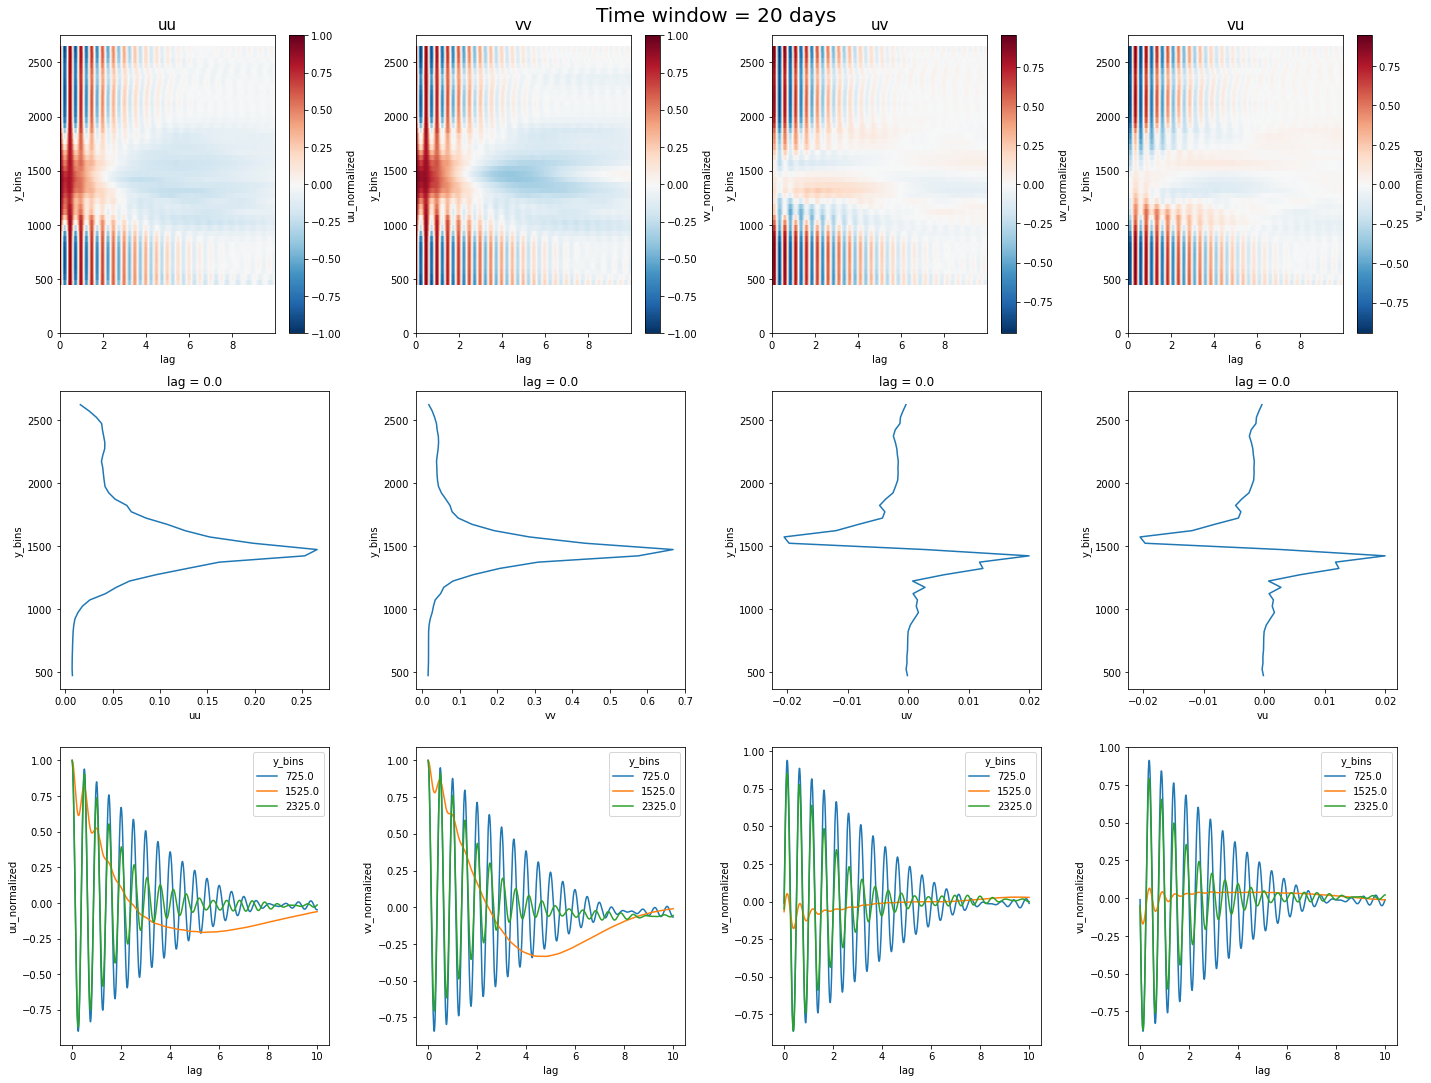

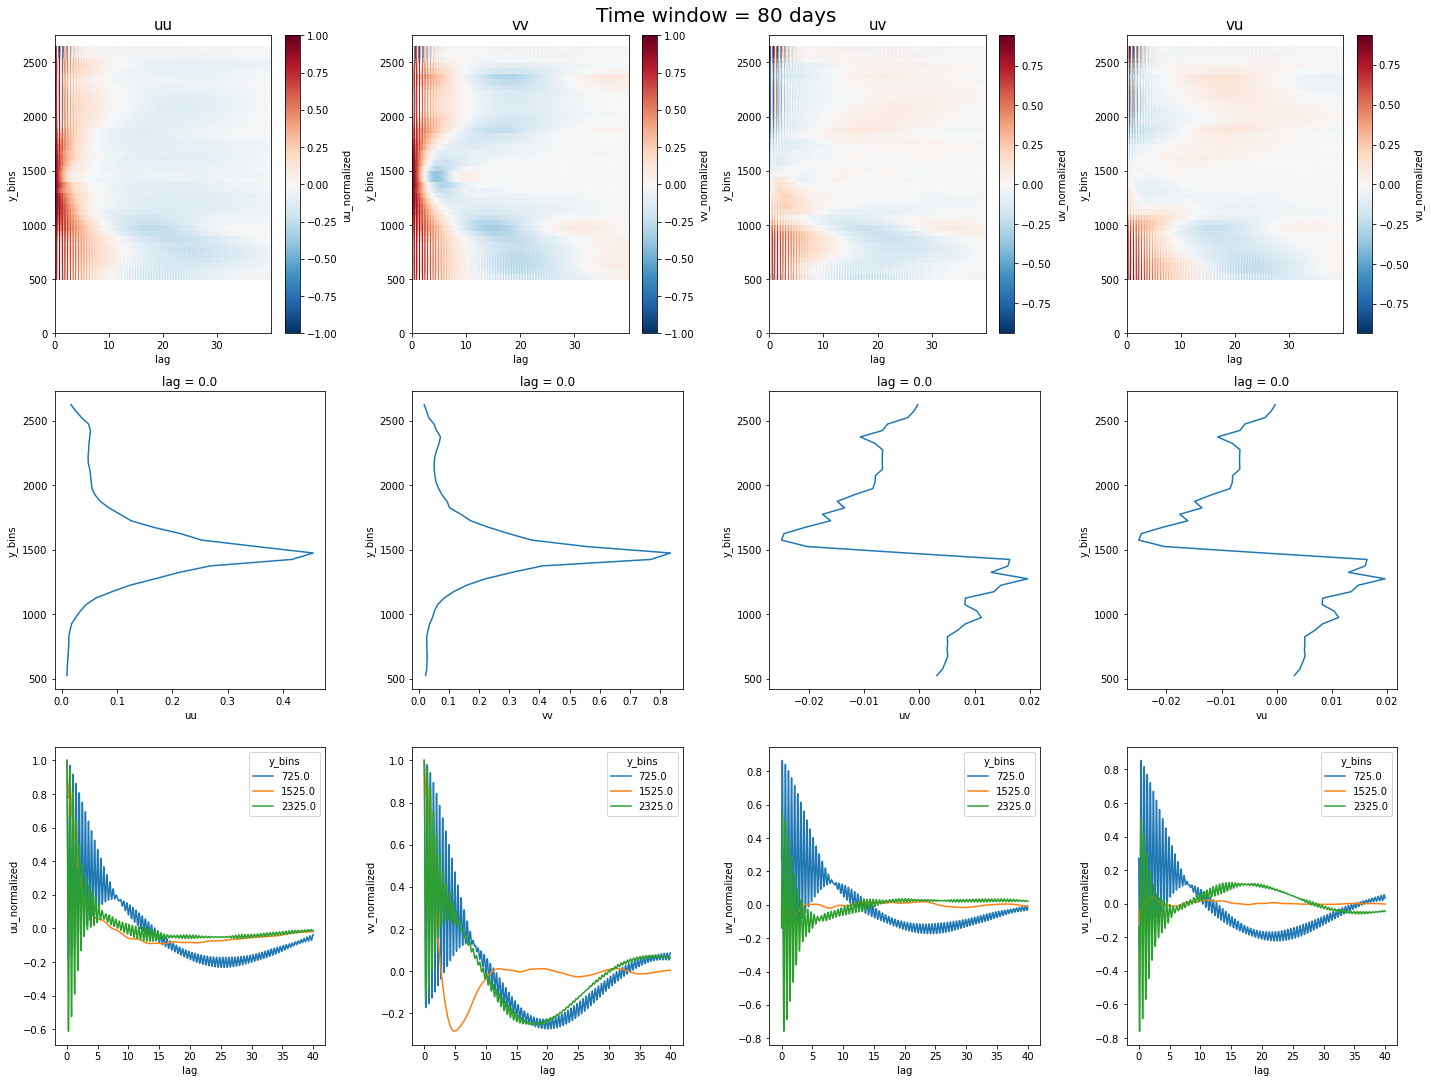

In [26]:
Y = [700, 1500, 2300]
for T in ds.keys():
    fig, axs = plt.subplots(3,4,figsize=(20,15))
    fig.suptitle('Time window = '+T+' days',x=0.5,y=1.,fontsize=20)
    for v, ax in zip(V, axs[0,:]):
        ds.get(T)[v+'_normalized'].plot(ax=ax)
    
#fig, axs = plt.subplots(1,3,figsize=(15,5))
    for v, ax in zip(V, axs[1,:]):
        ds.get(T)[v].sel(lag=0).plot(ax=ax, y='y_bins')

#fig, axs = plt.subplots(1,3,figsize=(15,5))
    for v, ax in zip(V, axs[2,:]):
        ds.get(T)[v+'_normalized'].sel(y_bins=Y, method='nearest').plot(ax=ax, x='lag', hue='y_bins')
    axs[0,0].set_title('uu',fontsize=15);axs[0,1].set_title('vv',fontsize=15);axs[0,2].set_title('uv',fontsize=15);
    axs[0,3].set_title('vu',fontsize=15)
    fig.tight_layout()

### Comments :


### Definition of the theoretical models used to describe our results

In [4]:
# Fast contribution
def Ctilde(t,Tt,nu):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,nu,Tb,Omega,r):
    return (1-r)*Cbar(t,Tb,Omega)+r*Ctilde(t,Tt,nu)

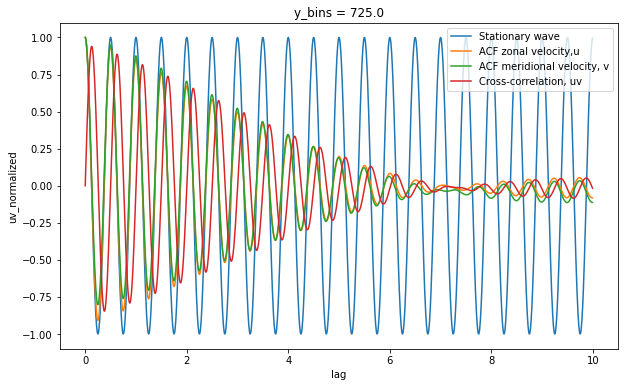

In [5]:
om = 2 #internal waves frequency
Tt = 1 #nonstationarity timescale

#illlustration of non-stationarity in the data (functions t y1 and expected signal for a stationary wave)
fig,ax = plt.subplots(figsize=(10,6))

ax.plot(ds.lag,np.cos(2*np.pi*om*ds.lag),label='Stationary wave') #Si l'onde était stationnaire

labels = ['ACF zonal velocity,u', 'ACF meridional velocity, v', 'Cross-correlation, uv']
for v, label in zip(V, labels):
    ds[v+'_normalized'].sel(y_bins=Y[0], method='nearest').plot(ax=ax,label=label)
ax.legend()

### Comparaison modèles théoriques et données (à la main):  in this part we only use the autocorrelation uu

On cherche à approcher au plus près les modèles théoriques à nos données en changeant différents paramètres ($\overline{T}$, $\widetilde{T}_{ns}$ et $\Omega$)

#### Theoritical model for  $\widetilde{C}$ :
$\widetilde{C} = e^{-\tau/\widetilde{T}_{ns}}cos(\omega\tau)$

Since we observe a node in our data we multiply arbitrarily by a term : $cos(\nu\tau)$

=> $\widetilde{C} = e^{-\tau/\widetilde{T}_{ns}}cos(\omega\tau)cos(\nu\tau)$
we will first vary $\widetilde{T}_{ns}$ then $\nu$

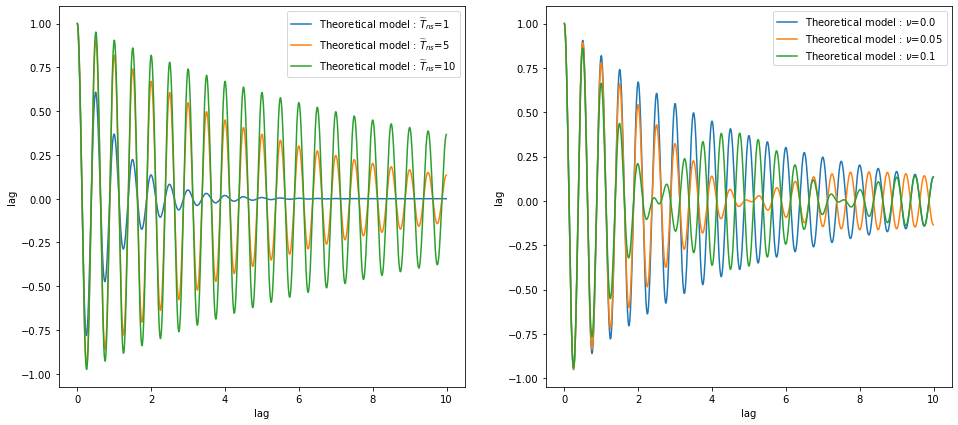

In [6]:
fig, ax = plt.subplots(1,2,figsize=(16,7))

for tns in [1, 5, 10]:
    Ctilde(ds.lag, tns,0.).plot(ax=ax[0], label=r'Theoretical model : $\widetilde{T}_{ns}$=%s'%(tns))
for nu in [0., .05, .1]:
    Ctilde(ds.lag, 5, nu).plot(ax=ax[1], label=r'Theoretical model : $\nu$=%s'%(nu))
ax[0].legend();ax[1].legend()

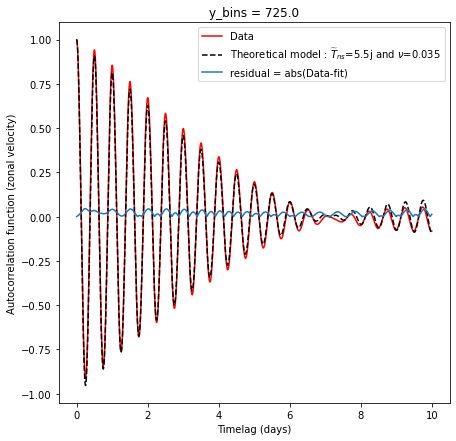

In [7]:
#A priori, we can expect only waves in this area (south of the jet) so we compare only to Ctilde function: 
fig,ax = plt.subplots(figsize=(7,7))
#plt.suptitle(r'y=%s km : best suited $\widetilde{T}_{ns}$ and $\nu$ '%uu.sel(y_bins=700,method='nearest').y_bins.values)
ds['uu_normalized'].sel(y_bins=Y[0], method='nearest').plot(ax=ax,c='r',label='Data')
plt.plot(ds.lag,Ctilde(ds.lag,5.5,0.035),'k--',label=r'Theoretical model : $\widetilde{T}_{ns}$=%s and $\nu$=%s'%(5.5j,0.035))
plt.plot(ds.lag, np.abs(ds['uu_normalized'].sel(y_bins=Y[0], method='nearest')-Ctilde(ds.lag,5.5,0.035)),label='residual = abs(Data-fit)')
plt.legend()
plt.xlabel('Timelag (days)');plt.ylabel('Autocorrelation function (zonal velocity)')
plt.savefig('/Users/zcaspar/Documents/Figs/y1_tilde.png')

#### Comments :
1 : $\widetilde{T}_{ns}$ controls the exponential decay of the envelop of the oscillations due to the waves. It won't create a node like it is observed in the data. However we know $\widetilde{T}_{ns}$ must not be to large otherwise the decay will be faster than the one observe. The oscillations are not completly damped in the data for lag=10. $\widetilde{T}_{ns}$=5days seems a good start to approximate the data.

2 : $\nu\neq0$ introduces a sinusoidal modulation of the oscillation from the data we expect a slow modulation, $\nu\ll\omega$. We see in the figure that $\nu=0.1$ leads to 2 nodes and $\nu=0.05$ to. node at shorter time than the one in the data. From this we search $\nu$ between 0 and 0.05.  

3 : By playing with the parameters taking into account the remarks made previously, we find $\widetilde{T}_{ns}$=5.5days and $\nu$=0.035$rad.s^{-1}$ an acceptable fit.


#### North from the jet (y=2325km): 
we use use again only the model for $\widetilde{C}$ as in the first case.

This time no node is expected so we can investigate first $\widetilde{T}_{ns}$ while fixing $\nu$ at 0.

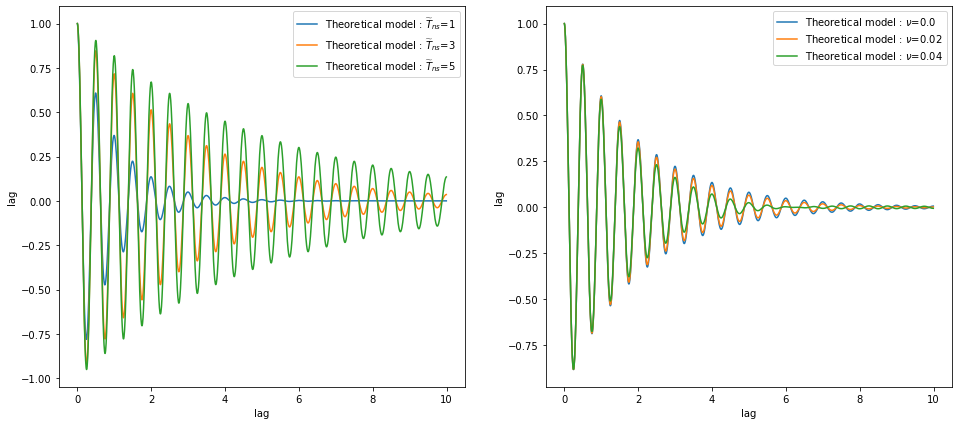

In [13]:
fig,ax = plt.subplots(1,2,figsize=(16,7))
for tns in [1, 3, 5]:
    Ctilde(ds.lag, tns,0.).plot(ax=ax[0], label=r'Theoretical model : $\widetilde{T}_{ns}$=%s'%(tns))
for nu in [0., .02, .04]:
    Ctilde(ds.lag, 2., nu).plot(ax=ax[1], label=r'Theoretical model : $\nu$=%s'%(nu))
ax[0].legend();ax[1].legend()
#ax[0].set_title(r'1) y=%s km : impact of $\widetilde{T}_{ns}$, $\nu$ is fixed to 0 (no node possible)'%
#                ds['uu_normalized'].sel(y_bins=Y[0], method='nearest').y_bins.values)
#ax[1].set_title(r'2) y=%s km : impact of $\nu$, $\widetilde{T}_{ns}$ fixed at 2days'%
#                ds['uu_normalized'].sel(y_bins=Y[0], method='nearest').y_bins.values)

#### Comments:
1 : The best $\widetilde{T}_{ns}$ expected seeems to be around 2 days. However there is a shift in the frequency of the fast oscillations that can not be reconstruct with our theoritical model.

2 : We fix this time $\widetilde{T}_{ns}$ at 2days and vary $\nu$. The variation of $\nu$ does not improve our approximation.

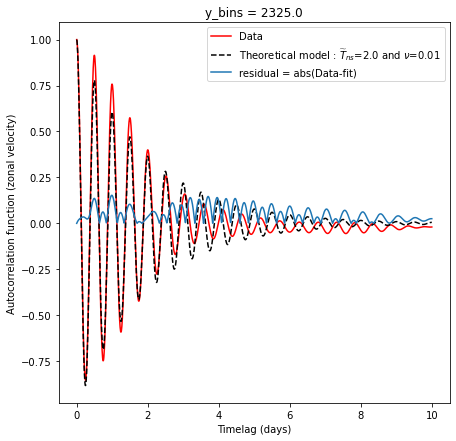

In [34]:
fig,ax = plt.subplots(figsize=(7,7))
ds['uu_normalized'].sel(y_bins=Y[2], method='nearest').plot(ax=ax,c='r',label='Data')
plt.plot(ds.lag,Ctilde(ds.lag,2.,0.01),'k--',label=r'Theoretical model : $\widetilde{T}_{ns}$=%s and $\nu$=%s'%(2.,0.01))
plt.plot(ds.lag, np.abs(ds['uu_normalized'].sel(y_bins=Y[2], method='nearest')-Ctilde(ds.lag,2.,0.01)),label='residual = abs(Data-fit)')
plt.legend()
plt.xlabel('Timelag (days)');plt.ylabel('Autocorrelation function (zonal velocity)')
plt.savefig('/Users/zcaspar/Documents/Figs/y1_tilde.png')

#### Theoritical model for  $\overline{C}$ :
$\widetilde{C} = e^{-\tau/\overline{T}}cos(\Omega\tau)$

we will first vary $\overline{T}$ then $\Omega$

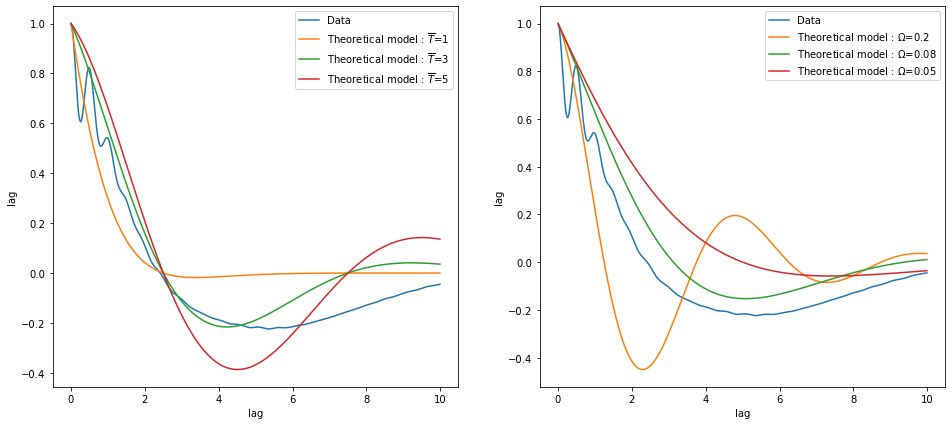

In [15]:
fig,ax = plt.subplots(1,2,figsize=(16,7))
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(ax=ax[1],label='Data')
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(ax=ax[0],label='Data')
for tbar in [1, 3, 5]:
    Cbar(ds.lag, tbar,0.1).plot(ax=ax[0], label=r'Theoretical model : $\overline{T}$=%s'%(tbar))
for omega in [0.2, .08, .05]:
    Cbar(ds.lag, 3., omega).plot(ax=ax[1], label=r'Theoretical model : $\Omega$=%s'%(omega))

ax[0].legend();ax[1].legend()
#ax[0].set_title(r'1) y=%s km : impact of $\overline{T}$, $\Omega$ is fixed to 0.1'%
#                ds['uu_normalized'].sel(y_bins=Y[1], method='nearest').y_bins.values)
#ax[1].set_title(r'2)y=%s km : impact of $\Omega$, $\overline{T}$ is fixed at 3days'%
#                ds['uu_normalized'].sel(y_bins=Y[1], method='nearest').y_bins.values)

#### Comments:
We assume that $\Omega\leq\omega$ because it is describing a slow motion. The fast oscillations at shorter times will not be described by $\bar C$. In the data we seem to see almost 1 period in the 10 days or at least the beginning of one. So we can expect $\Omega$ to be around 1/10. This one is far more difficult to fit than the pevious case.

1 : We first fix $\Omega=0.1$ and try to estimate $\bar T$ from there. We find 3 a good start for an approximation and observe at this point that $\Omega=0.1$ is surely an overestimation.

2 : From this observation we fix $\bar T$ at 3days and vary $\Omega$. We find $\Omega=0.08$ a good fit.

The last part consist at estimating the acceptable combination wich gives : $\overline{T}=3.5days$ and $\Omega=0.075$

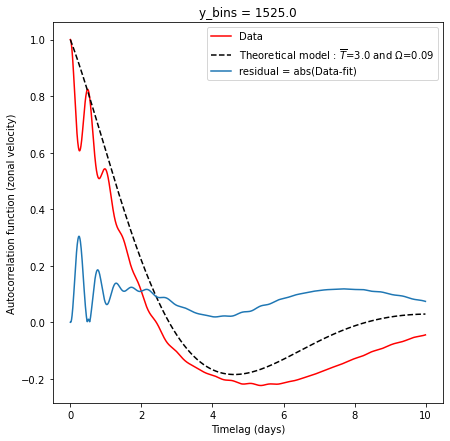

In [36]:
fig,ax = plt.subplots(figsize=(7,7))
ds['uu_normalized'].sel(y_bins=Y[1], method='nearest').plot(ax=ax,c='r',label='Data')
plt.plot(ds.lag,Cbar(ds.lag,3.,0.09),'k--',label=r'Theoretical model : $\overline{T}$=%s and $\Omega$=%s'%(3.,0.09))
plt.plot(ds.lag, np.abs(ds['uu_normalized'].sel(y_bins=Y[1], method='nearest')-Cbar(ds.lag,3.,0.09)),label='residual = abs(Data-fit)')
plt.legend()
plt.xlabel('Timelag (days)');plt.ylabel('Autocorrelation function (zonal velocity)')
plt.savefig('/Users/zcaspar/Documents/Figs/y1_tilde.png')

#### Comments : 
Here we have 2 main problems. The first one is easy to solve, the formula for $\bar C$ does not take into account the internal tides. The oscillations seen on our data will be illustrated when we take the whole formula for see (with r small but not null).

The second misfit we observe is on the envelop which is a bigger problem since it won't change when fitting to C. 

#### Complete formula:
The use only parts of the theoritical model depending on the region is not entirely satisfactory. The autocorrelation function using only the fast component is efficient south from the jet. The 2 other tested cases are not described well by simplification. We will now try and fit them to the complete formula.

#### In the jet :
For the case in the jet, we take the parameter $\Omega$ and $\overline{T}$ found previously. We will not vary them in the following part. r is supposed to be small.

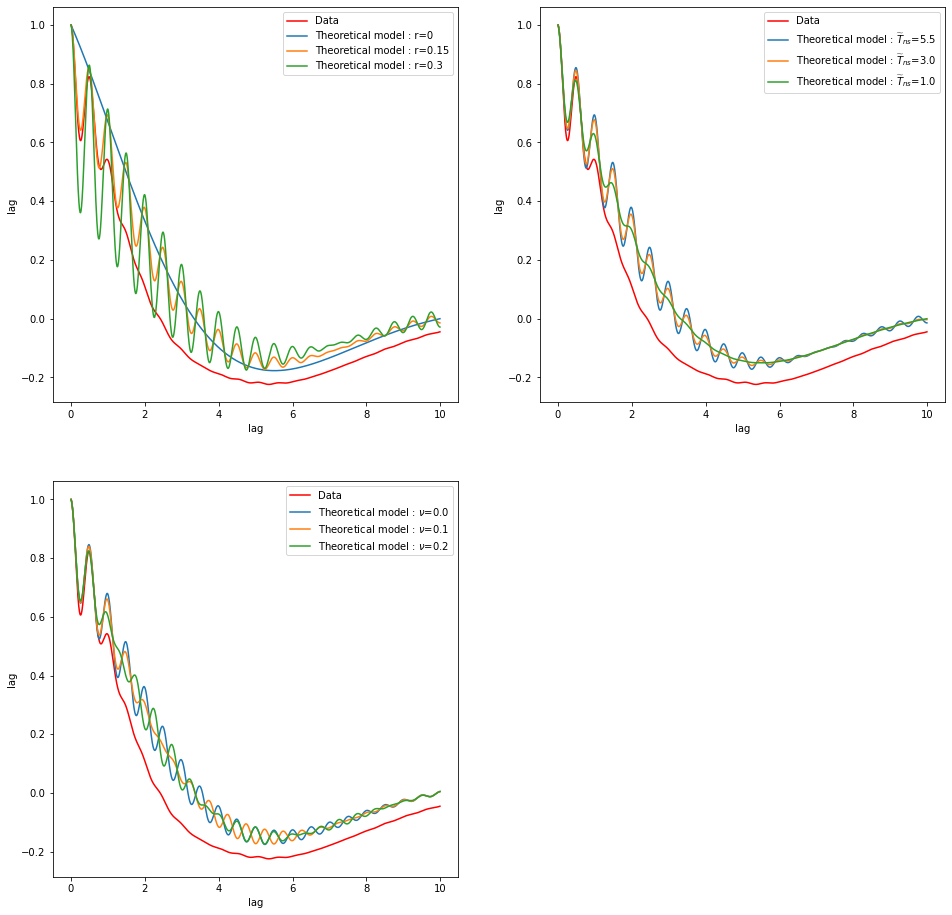

In [23]:
fig,ax = plt.subplots(2,2,figsize=(16,16))
fig.delaxes(ax[1,1])
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(ax=ax[0,1],c='r',label='Data')
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(ax=ax[0,0],c='r',label='Data')
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(ax=ax[1,0],c='r',label='Data')
for r in [0, .15, .3]:
    C(ds.lag, 5.5,0.035,3.5,0.075,r).plot(ax=ax[0,0], label=r'Theoretical model : r=%s'%(r))
for tns in [5.5, 3., 1.]:
    C(ds.lag, tns,0.035,3.5,0.075,0.15).plot(ax=ax[0,1], label=r'Theoretical model : $\widetilde{T}_{ns}$=%s'%(tns))
for nu in [0., .1, .2]:
    C(ds.lag, 3,nu,3.5,0.075,0.15).plot(ax=ax[1,0], label=r'Theoretical model : $\nu$=%s'%(nu))

ax[0,0].legend();ax[0,1].legend();ax[1,0].legend()

#### Comments : 
1) r controls the weight of each component ($\overline{C}$ and $\widetilde{C}$). Consequently we can approximate the value of r using the form of the oscillations. Clearly the effect of the jet dominates here but a value of r=0.15 (black line) seems to be close of the visible oscillations on the data (red line).

2) $\widetilde{T}_{ns}$ controls the decay of the amplitude of the fast oscillations. They are slightly visible at highest timelag so in our example $\widetilde{T}_{ns}$=3days seems the best guess.

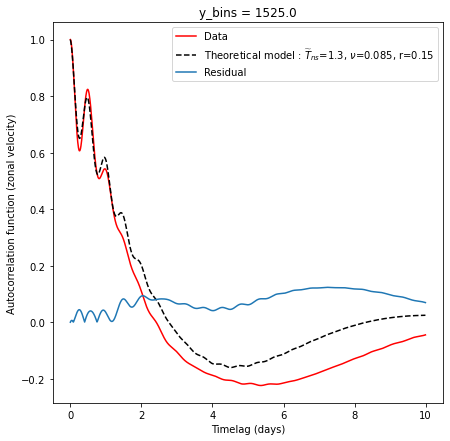

In [27]:
#plt.set_title(r'2) y=%s km : impact of $\nu$'%
#             uu.sel(y_bins=1500,method='nearest').y_bins.values)
plt.figure(figsize=(7,7))
ds['uu_normalized'].sel(y_bins=Y[1],method='nearest').plot(c='r',label='Data')
plt.plot(ds.lag, C(ds.lag,1.3,0.085,3.,0.09,0.15),'k--',label=r'Theoretical model : $\widetilde{T}_{ns}$=1.3, $\nu$=0.085, r=0.15')
plt.plot(ds.lag, np.abs(ds['uu_normalized'].sel(y_bins=Y[1],method='nearest')-C(ds.lag,1.3,0.085,3.,0.09,0.15)),label='Residual')
plt.legend()
plt.xlabel('Timelag (days)');plt.ylabel('Autocorrelation function (zonal velocity)')
plt.savefig('/Users/zcaspar/Documents/Figs/y2_C.png')

### Generalization of the method for the fit using scipy.optimize.curve_fit : 

In [67]:
yfit,params,cov = fit(tau,uu.sel(y_bins=1500,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))


In [139]:
pa,co = scipy.optimize.curve_fit(C,tau,y1[0],bounds=(0.,[10.,1.,10.,0.5,1.]))
yf = C(tau, *[p for p in pa])

In [154]:
pacov = xr.DataArray(np.hstack([pa,np.sqrt(np.diag(co))])).expand_dims('ybin').assign_coords({'ybin':np.array([725])})

In [160]:
pacov.sel(dim_0=1)

<xarray.DataArray (ybin: 1)>
array([0.03383328])
Coordinates:
  * ybin     (ybin) int64 725

In [163]:
d = dict(zip(['yfit','Tns','nu','Tbar','Omega','r','Errtns','Errnu','Errtbar','Errom','Err_r'],
             [yf,[pacov.sel(dim_0=i) for i in range(10)]]))
d

{'yfit': <xarray.DataArray 'lag' (lag: 1440)>
 array([ 1.        ,  0.9951732 ,  0.98297589, ..., -0.10514567,
        -0.10715502, -0.10841239])
 Coordinates:
   * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993,
 'Tns': array([6.14668913e+00, 3.38332751e-02, 1.00000000e+01, 5.82105451e-02,
        9.75331385e-01, 2.33416036e-02, 4.96694486e-05, 8.27964416e-01,
        1.18795938e-03, 8.21025847e-04])}

In [168]:
dict(zip(['a','v','n'],[0,[0,1]]))
#[pacov.sel(dim_0=i) for i in range(10)]
#xr.Dataset(d)

{'a': 0, 'v': [0, 1]}

In [106]:
yf = yf.expand_dims('ybin').assign_coords({'ybin':np.array([725])})

In [107]:
xr.Dataset({'yfit':yf,'Tns':np.array([params[0]]),'nu':np.array([params[1]]),'Tbar':np.array([params[2]]),
            'Omega':np.array([params[4]]),'r':np.array([params[4]])})

<xarray.DataArray 'lag' (ybin: 1, lag: 1440)>
array([[ 1.        ,  0.99500789,  0.98246053, ..., -0.0912366 ,
        -0.09313279, -0.09432304]])
Coordinates:
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
  * ybin     (ybin) int64 725

In [74]:
y = uu.sel(y_bins=1500,method='nearest').y_bins.values

In [94]:
xr.DataArray(np.array([params[0]]),dims=('ybin'),coords={'ybin':np.array([y])})

<xarray.DataArray (ybin: 1)>
array([0.55671961])
Coordinates:
  * ybin     (ybin) float64 1.525e+03

In [96]:
xr.Dataset({'yfit':yfit,'Tns':xr.DataArray(np.array([params[0]]),dims=('ybin'),coords={'ybin':np.array([y])})})

<xarray.Dataset>
Dimensions:  (lag: 1440, ybin: 1)
Coordinates:
  * lag      (lag) float64 0.0 0.006944 0.01389 0.02083 ... 9.979 9.986 9.993
  * ybin     (ybin) float64 1.525e+03
Data variables:
    yfit     (lag) float64 1.0 0.9948 0.9877 0.9789 ... 0.05226 0.05243 0.05261
    Tns      (ybin) float64 0.5567

In [66]:
yfit.attrs['Tns'] = params[0]
yfit.attrs['nu']  = params[1]
yfit.attrs['Tbar'] = params[2]
yfit.attrs['Omega'] = params[3]
yfit.attrs['r'] = params[-1] 

In [5]:
def fit(t,y,myfunc,bounds): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params,cov=[None,None]
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)
        yfit = myfunc(tau,*[p for p in params])
    return xr.Dataset(yfit,params,cov)

def plot_fit(t,y,myfunc,params,bounds,ax):
    """Plot the fit, the data and the residual (difference btw fit and data)
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        params : parameters used to plot the fit : if None,  they will be computed using the function fit
        bounds : bounds of the parameters to fit 
        ax : axis where the plot will be done
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    if params == None:
#        Tns,nu,Tbar,Omega,r = fit(tau,y,myfunc,bounds)[1]
        yfit, params = fit(t,y,myfunc,bounds)[0:2]
    else : 
        #Tns,nu,Tbar,Omega,r = args
        yfit = myfunc(t,*[p for p in params])
    if len(params)==5:
        ax.set_title(r'$\widetilde{T}_{ns}$=%s, $\nu$=%s, $\bar T$=%s, $\Omega$=%s and r=%s'%
                  tuple([np.around(i,decimals=3) for i in params ]))
    elif len(params)==2:
        ax.set_title(r'Timescale : %s, Frequency of slow oscillation : %s'%
                  tuple([np.around(i,decimals=3) for i in params ]))
    ax.plot(t,y,'r',label='Data')
    ax.plot(t,yfit,'k--',label='Theoretical model')
    ax.plot(t,np.abs(y-yfit),label='Residual')
    ax.legend()
    return yfit, params#[Tns,nu,Tbar,Omega,r]

### South


Text(0.0, 1.25, 'Meridional velocity autocorrelation function, vv')

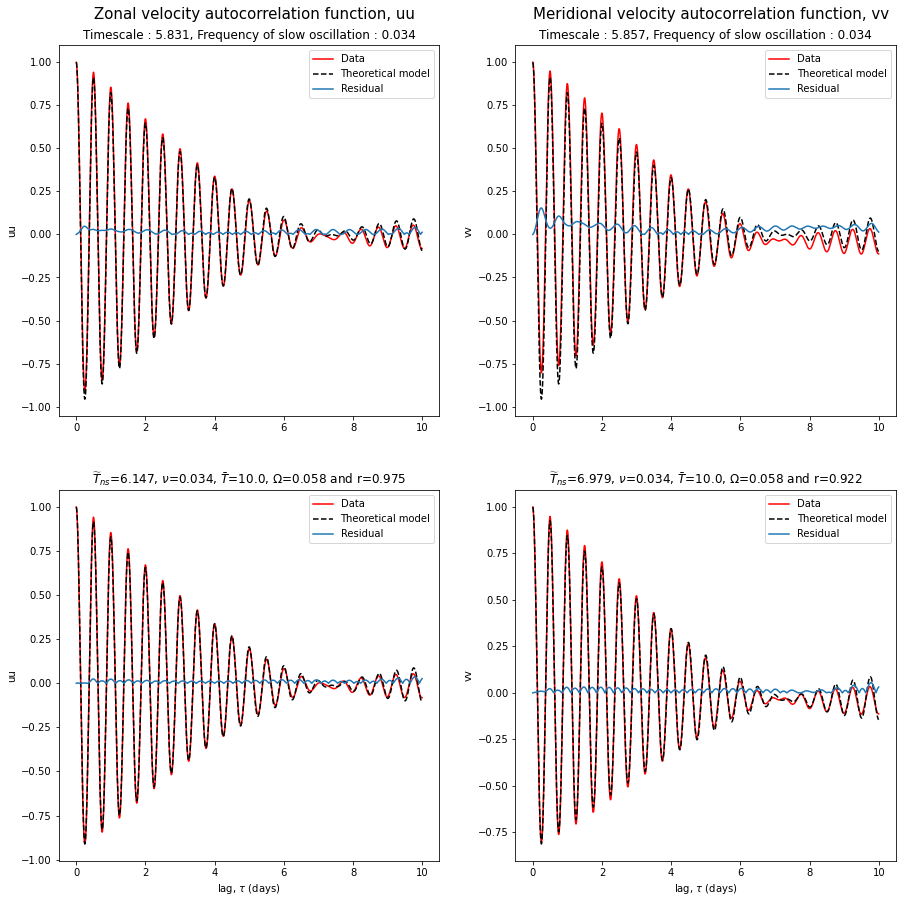

In [53]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsu1 = plot_fit(tau,y1[0],Ctilde,None,(0.,[10.,1.]),ax[0,0])
resultsv1 = plot_fit(tau,y1[1],Ctilde,None,(0.,[10.,1.]),ax[0,1])
resultsu1 = plot_fit(tau,y1[0],C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsv1 = plot_fit(tau,y1[1],C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu');ax[1,1].set_ylabel(r'vv')
ax[0,0].set_ylabel(r'uu');ax[0,1].set_ylabel(r'vv')
ax[0,0].text(0.5,1.25,'Zonal velocity autocorrelation function, uu', fontsize=15)
ax[0,1].text(0.,1.25,'Meridional velocity autocorrelation function, vv', fontsize=15)

### Jet:

Text(0.0, 1.25, 'Meridional velocity autocorrelation function, vv')

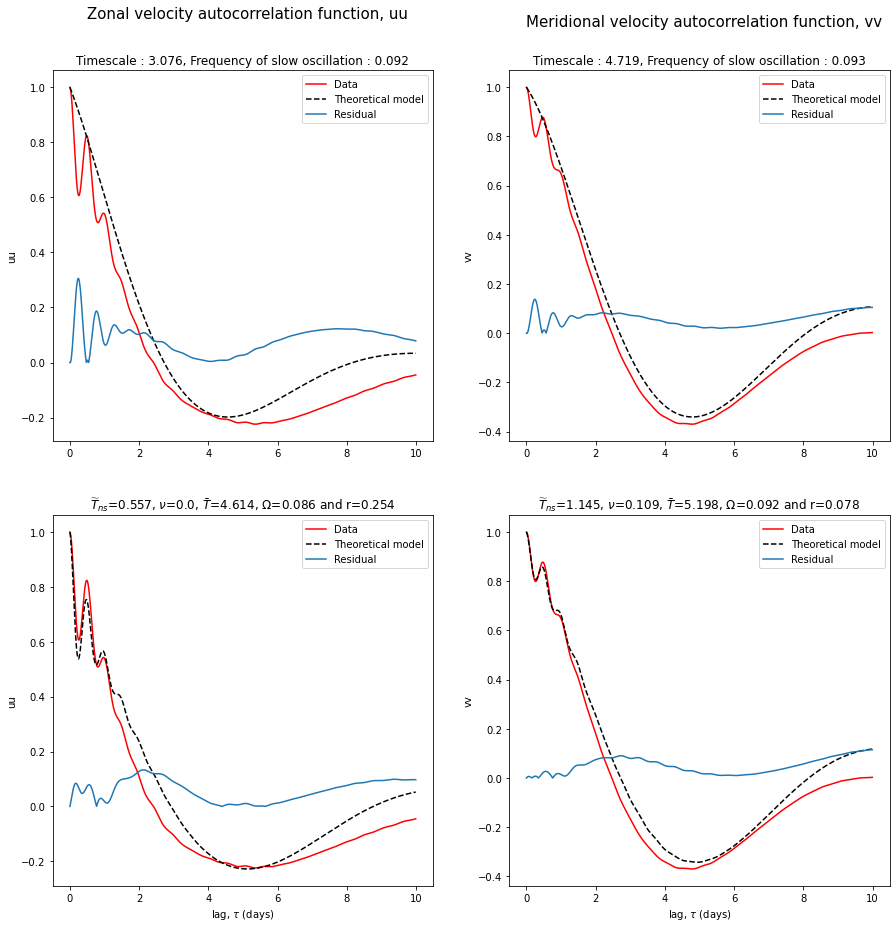

In [54]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsu2 = plot_fit(tau,y2[0],Cbar,None,(0.,[10.,1.]),ax[0,0])
resultsv2 = plot_fit(tau,y2[1],Cbar,None,(0.,[10.,1.]),ax[0,1])
resultsu2 = plot_fit(tau,y2[0],C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsv2 = plot_fit(tau,y2[1],C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu');ax[1,1].set_ylabel(r'vv')
ax[0,0].set_ylabel(r'uu');ax[0,1].set_ylabel(r'vv')
ax[0,0].text(0.5,1.25,'Zonal velocity autocorrelation function, uu', fontsize=15)
ax[0,1].text(0.,1.25,'Meridional velocity autocorrelation function, vv', fontsize=15)

### North

Text(0.0, 1.25, 'Meridional velocity autocorrelation function, vv')

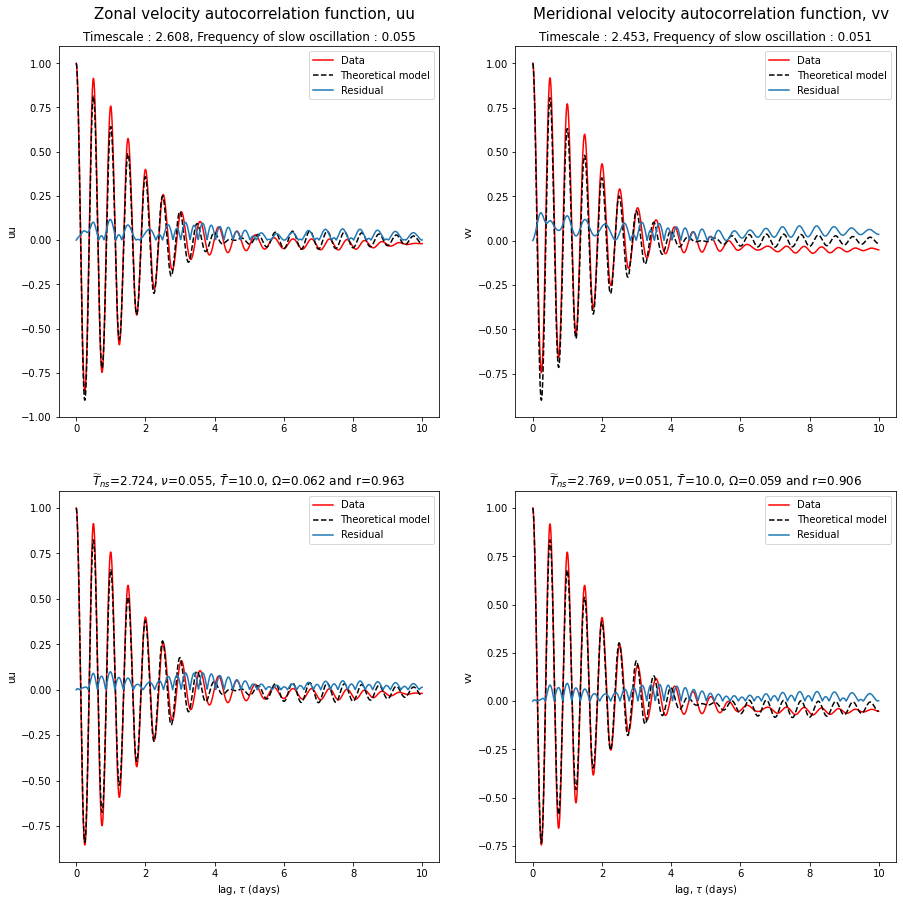

In [55]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsu3 = plot_fit(tau,y3[0],Ctilde,None,(0.,[10.,1.]),ax[0,0])
resultsv3 = plot_fit(tau,y3[1],Ctilde,None,(0.,[10.,1.]),ax[0,1])
resultsu3 = plot_fit(tau,y3[0],C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsv3 = plot_fit(tau,y3[1],C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu');ax[1,1].set_ylabel(r'vv')
ax[0,0].set_ylabel(r'uu');ax[0,1].set_ylabel(r'vv')
ax[0,0].text(0.5,1.25,'Zonal velocity autocorrelation function, uu', fontsize=15)
ax[0,1].text(0.,1.25,'Meridional velocity autocorrelation function, vv', fontsize=15)

The fits seem better than our approximation but it creates a node that is not in the data to fit the shift in frequency. The use of the full formula seems to be  bit better. But the r found is still close to 1.

#### Comments:
The problem with a fit with so much variables (5) is that it just search for the best fit without taking into account the small features that may have a significant physical meaning. Here for example there seems to be 2 nodes with slight increase of the amplitude of fast oscillations around $\tau$ = 5 days and $\tau$=9. This is not visible in the output of curve_fit. 

Here I blocked the values of $\bar T$ and $\Omega$ around the ones found with the first fit (with only $\bar C$) wothout this constraints the results are meaningless. It will be important to set carefully  the bounds in the future.

### Estimation of parameters using fit

In [16]:
uuparams, erru = np.zeros((uu.y_bins.size,5)),np.zeros((uu.y_bins.size,5))
for i,y in enumerate(uu.y_bins.values):
    uuparams[i,:]=fit(tau,uu.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[1]
    erru[i,:] = np.sqrt(np.diag(fit(tau,uu.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[2]))
vvparams, errv = np.zeros((uu.y_bins.size,5)),np.zeros((uu.y_bins.size,5))
for i,y in enumerate(vv.y_bins.values):
    vvparams[i,:]=fit(tau,vv.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[1]
    errv[i,:] = np.sqrt(np.diag(fit(tau,vv.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[2]))

ValueError: Input must be 1- or 2-d.

In [22]:
type(fit(tau,uu.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[2])

NoneType

In [28]:
_uu.apply('uu',fit,tau,C,(0.,[10.,1.,10.,0.5,1.]))

TypeError: apply() takes from 2 to 4 positional arguments but 6 were given

#### Plot of the different parameters computed for the autocorrelation functions (depending on y)

Text(0.5, 0.98, 'Variations of best fit parameters depending in y for the autocorrelation function (uu and vv)')

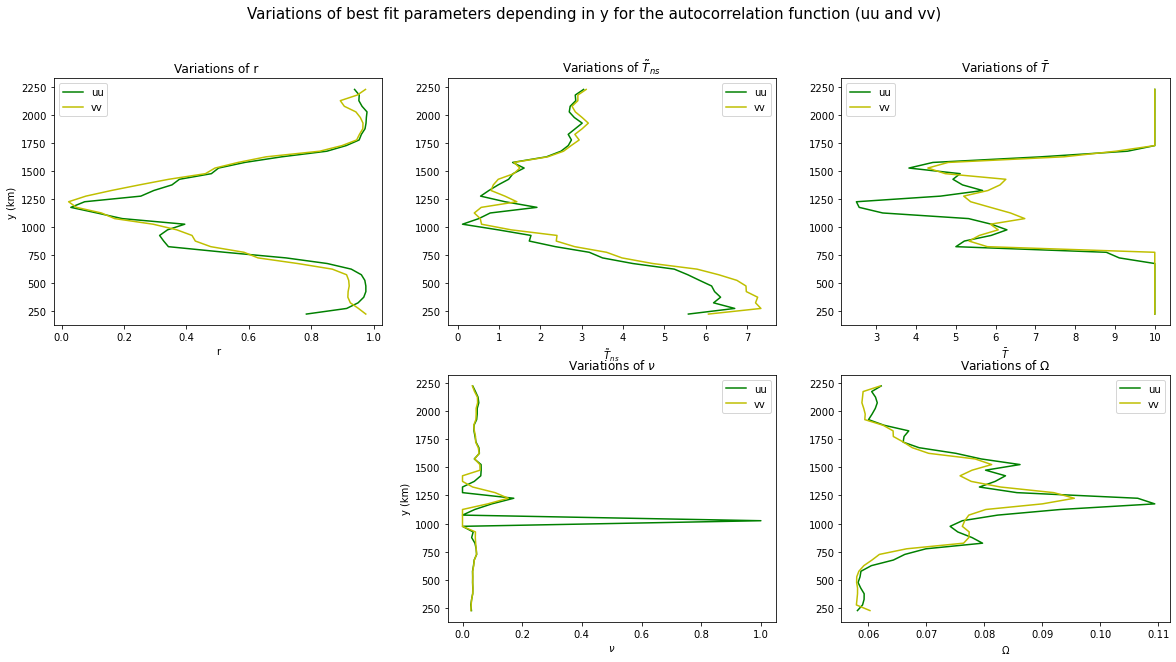

In [61]:
ybins = uu.y_bins.values[:-5]
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].plot(uuparams[5:-5,-1],ybins[:-5],'g',label='uu')
ax[0,0].plot(vvparams[5:-5,-1],ybins[:-5],'y',label='vv')
ax[0,0].legend()
ax[0,0].set_title('Variations of r ')
ax[0,0].set_ylabel('y (km)');ax[0,0].set_xlabel('r')
ax[0,1].plot(uuparams[5:-5,0],ybins[:-5],'g',label='uu')
ax[0,1].plot(vvparams[5:-5,0],ybins[:-5],'y',label='vv')
ax[0,1].legend();ax[0,1].set_xlabel(r'$\tilde T_{ns}$')
ax[0,1].set_title(r'Variations of $\tilde T_{ns}$ ')
ax[0,2].plot(uuparams[5:-5,2],ybins[:-5],'g',label='uu')
ax[0,2].plot(vvparams[5:-5,2],ybins[:-5],'y',label='vv')
ax[0,2].legend();ax[0,2].set_xlabel(r'$\bar T$')
ax[0,2].set_title(r'Variations of $\bar T$ ')
ax[1,1].plot(uuparams[5:-5,1],ybins[:-5],'g',label='uu')
ax[1,1].plot(vvparams[5:-5,1],ybins[:-5],'y',label='vv')
ax[1,1].legend();ax[1,1].set_xlabel(r'$\nu$')
ax[1,1].set_title(r'Variations of $\nu$ ')
ax[1,2].plot(uuparams[5:-5,3],ybins[:-5],'g',label='uu')
ax[1,2].plot(vvparams[5:-5,3],ybins[:-5],'y',label='vv')
ax[1,2].legend();ax[1,2].set_xlabel(r'$\Omega$')
ax[1,1].set_ylabel('y (km)')
ax[1,2].set_title(r'Variations of $\Omega$ ')
fig.delaxes(ax[1,0])
fig.suptitle('Variations of best fit parameters depending in y for the autocorrelation function (uu and vv)',fontsize=15)

#### Comments :
In this part, the fit have been computed using the function scipy.optimize.curve_fit for every y_bins (middle y from the bins used in the averaging).\
The variations of the parameters are cohrent with what we would expect in this situation : 

1) r is low in the jet area and increases towards 1 in the area far from the jet. However the area where r is the closest to zero does not coincide with the center of the jet but is a bit lower in the domain (centered around 1200km against 1500km for the kinetic energy maximum).\
2) $\tilde T_{ns}$ is high at small y (<600km) but decreases quickly in the area of the jet and remains around 3 days at higher y.\
3) $\bar T$ can be interpreted in the area between 750km and 1700km. It stays around 5-6 days for v and between 4-5 days for u, with a low point in the latter case of less than 3 days for y$\in$[1100;1250]. Outside of this area, it takes the highest bound put in the fit (whatever this value is).\
4) Low values of $\nu$ for both v and u with a peak at 0.2 centered at 1250km. Anomaly for u for y$\simeq$1000km (to b einvestigated, must be an incoherence in the fit).\
5) $\Omega$ is hier in the area of the jet with a maximum of around 0.1 for v and 0.11 for u corresponding to y$\simeq$1250km. Decreases again for high y until reaching values similar to the ones found at low y (no large differences btw the area far from the jet). 

Strangely, all the peaks or pits in our paramteter are centered around 1250km and not 1500km which is the center of the jet...?

### Comparison eulerian and lagrangian : 

In [65]:
_uuEL = xr.open_dataset(path+'diags/corr_20.nc')
uuL = uu#_uu.L_corr/_uu.L_corr.sel(lag=0)

uuE = _uuEL.E_corr.assign_coords(y_rho=_uuEL.E_corr.y_rho/1000)
#uuE = uuE.groupby_bins('y_rho',ybin-10).mean()#uuE.groupby_bins('y_rho',int((uuE.y_rho.max()-uuE.y_rho.min())/50)).mean()
uuE = uuE/uuE.sel(lags=0)

ybin = np.hstack([uuL.y_bins.values])

uuE = uuE.sel(y_rho=slice(0,2750)).groupby_bins('y_rho',ybin.size).mean()

uuE = uuE.assign_coords({'y_rho_bins':ybin})

In [66]:
lag = uuL.lag.values
lags = uuE.lags.values
yL1 = uuL.sel(y_bins=700,method='nearest')
yL2 = uuL.sel(y_bins=1500,method='nearest')
yL3 = uuL.sel(y_bins=2300,method='nearest')
yE1 = uuE.sel(y_rho_bins=700,method='nearest').values
yE2 = uuE.sel(y_rho_bins=1500,method='nearest').values
yE3 = uuE.sel(y_rho_bins=2300,method='nearest').values

Text(4, 3000, 'Lagrangian')

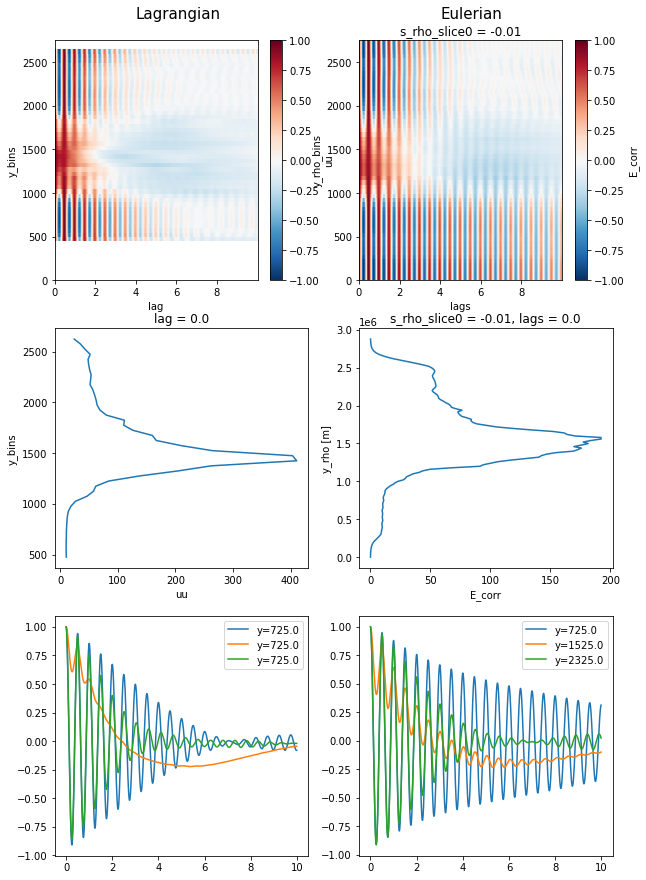

In [73]:
fig,ax = plt.subplots(3,2,figsize=(10,15))
uuL.plot(ax=ax[0,0])
_uu.uu.sel(lag=0).plot(ax=ax[1,0],y='y_bins')
ax[2,0].plot(lag,yL1,label='y=%s'%yL1.y_bins.values)
ax[2,0].plot(lag,yL2,label='y=%s'%yL1.y_bins.values)
ax[2,0].plot(lag,yL3,label='y=%s'%yL1.y_bins.values)
ax[2,0].legend()
uuE.plot(ax=ax[0,1])
_uuEL.E_corr.sel(lags=0).plot(ax=ax[1,1],y='y_rho')
ax[2,1].plot(lags,yE1,label='y=%s'%yL1.y_bins.values)
ax[2,1].plot(lags,yE2,label='y=%s'%yL2.y_bins.values)
ax[2,1].plot(lags,yE3,label='y=%s'%yL3.y_bins.values)
ax[2,1].legend()
ax[0,1].text(4,3000,'Eulerian', fontsize=15)
ax[0,0].text(4,3000,'Lagrangian', fontsize=15)

### Fit : eulerian vs lagrangian (zonal velocity autocorrelation)

### South :

Text(4, 1.25, 'Lagrangian')

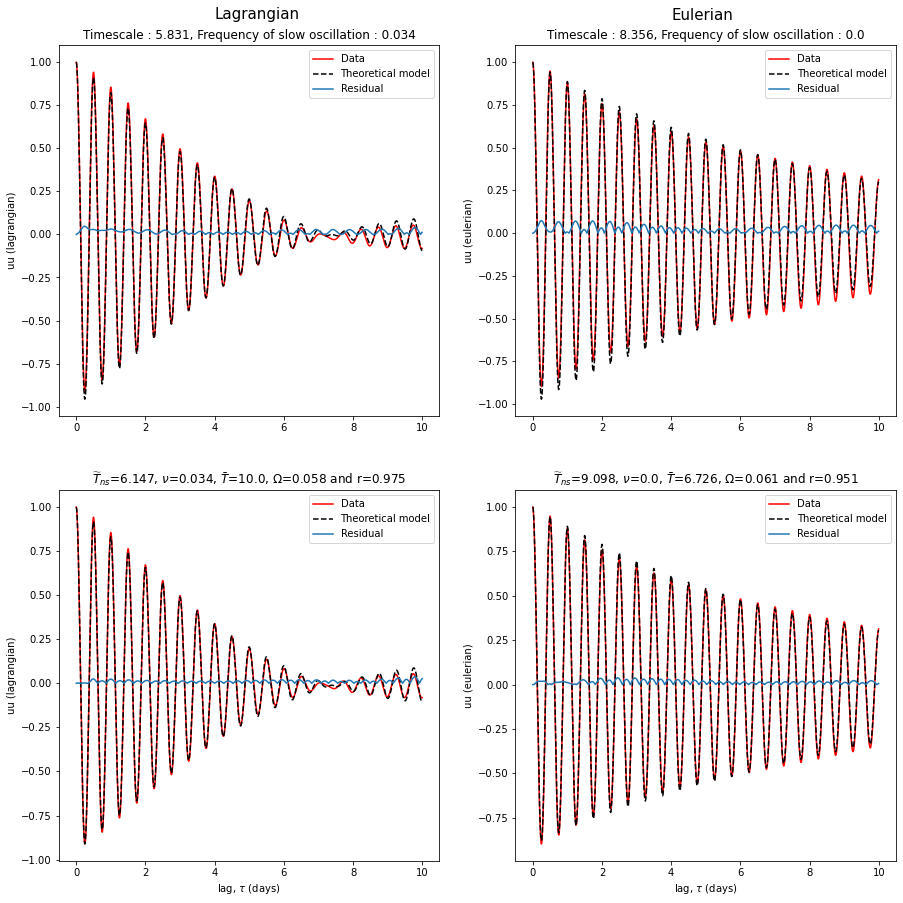

In [74]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsL1 = plot_fit(lag,yL1,Ctilde,None,(0.,[10.,1.]),ax[0,0])
resultsE1 = plot_fit(lags,yE1,Ctilde,None,(0.,[10.,1.]),ax[0,1])
resultsL1 = plot_fit(lag,yL1,C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsE1 = plot_fit(lags,yE1,C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu (lagrangian)');ax[1,1].set_ylabel(r'uu (eulerian)')
ax[0,0].set_ylabel(r'uu (lagrangian)');ax[0,1].set_ylabel(r'uu (eulerian)')
ax[0,1].text(4,1.25,'Eulerian', fontsize=15)
ax[0,0].text(4,1.25,'Lagrangian', fontsize=15)

### Comments : 
In both perspectives, the model using only the fast contribution seems to be efficient to describe the data with little improvement shown using th total model (r close to one).\
The lagrangian non-stationarity timescale is lower than the eulerian one (5-days vs 8-9days).\
When using the full formula, C, we find close $\Omega$ ($\simeq$0.6). The decorrelation timescale is lower in the eulerian case. However this is difficult to interpret with such value of r ($\simeq$0.96).

### Jet:

Text(4, 1.25, 'Lagrangian')

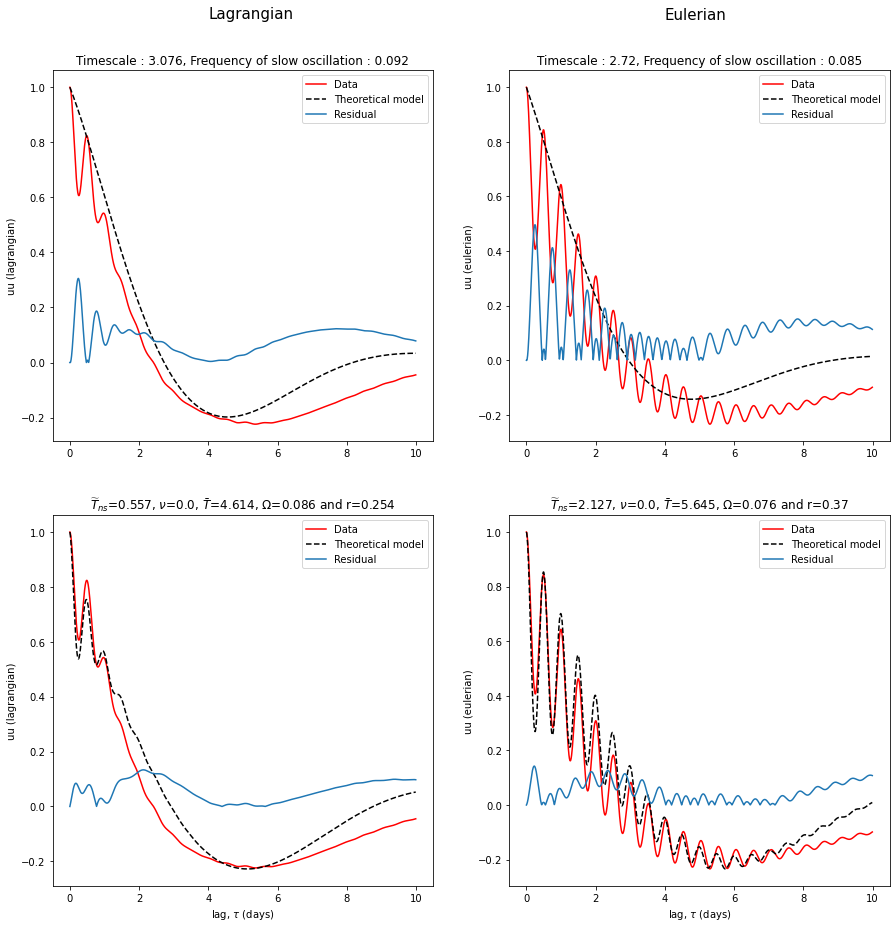

In [75]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsL2 = plot_fit(lag,yL2,Cbar,None,(0.,[10.,1.]),ax[0,0])
resultsE2 = plot_fit(lags,yE2,Cbar,None,(0.,[10.,1.]),ax[0,1])
resultsL2 = plot_fit(lag,yL2,C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsE2 = plot_fit(lags,yE2,C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu (lagrangian)');ax[1,1].set_ylabel(r'uu (eulerian)')
ax[0,0].set_ylabel(r'uu (lagrangian)');ax[0,1].set_ylabel(r'uu (eulerian)')
ax[0,1].text(4,1.25,'Eulerian', fontsize=15)
ax[0,0].text(4,1.25,'Lagrangian', fontsize=15)

### Comments :
Only $\bar C$ :\
The fast oscillations are not taken into account (expected seeing what model we use).\
Higher decorrelation timescale in lagrangian ($\sim$3 vs $\sim$2.7 not much differences)\
Totla formula, C :\
Fast oscillations with non-stationarity timescale $\tilde T_{ns}$ less than 1 day in the lagrangian perspective ($\sim$2 in eulerian).\
In this case the timescale, $\bar T$ si higher in eulerian (4.6 vs 5.6) (which one is to be trusted??)\
In both cases the decrease of the fast oscillations is not very well described .

### North : 

Text(4, 1.25, 'Lagrangian')

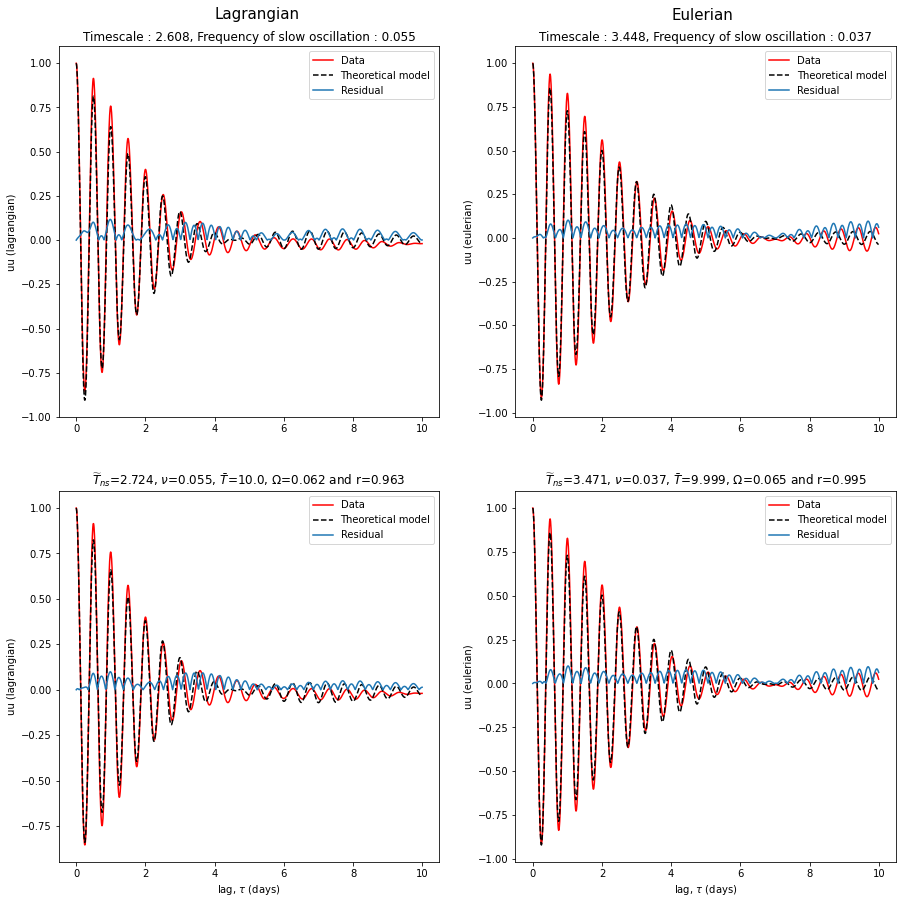

In [76]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
resultsL3 = plot_fit(lag,yL3,Ctilde,None,(0.,[10.,1.]),ax[0,0])
resultsE3 = plot_fit(lags,yE3,Ctilde,None,(0.,[10.,1.]),ax[0,1])
resultsL3 = plot_fit(lag,yL3,C,None,(0.,[10.,1.,10.,0.5,1.]),ax[1,0])
resultsE3 = plot_fit(lags,yE3,C,None,(0.,[10.,1.,10.,0.1,1.]),ax[1,1])
ax[1,0].set_xlabel(r'lag, $\tau$ (days)');ax[1,1].set_xlabel(r'lag, $\tau$ (days)')
ax[1,0].set_ylabel(r'uu (lagrangian)');ax[1,1].set_ylabel(r'uu (eulerian)')
ax[0,0].set_ylabel(r'uu (lagrangian)');ax[0,1].set_ylabel(r'uu (eulerian)')
ax[0,1].text(4,1.25,'Eulerian', fontsize=15)
ax[0,0].text(4,1.25,'Lagrangian', fontsize=15)

### Comments : 
We observe a shift in frequency in the lagrangian data, where it is not observe in the eulerian one (instread we observe a node). The shift in lagrangian is not described by our model.\
We find a r close to 1 ($\sim$0.98) and $\tilde T_{ns}$ close to each other with the eulerian one higher ($\sim$2.65 in lagrangian and $\sim$3.46 in eulerian)

### Estimation of parameters for all y in lagrangian and eulerian (still for the autocorrelation of u) :

In [78]:
Lparams =np.zeros((uuL.y_bins.size,5))
for i,y in enumerate(uuL.y_bins.values):
    Lparams[i,:]=fit(lag,uuL.sel(y_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[1]
Eparams =np.zeros((uuL.y_bins.size,5))
for i,y in enumerate(uuL.y_bins.values):
    Eparams[i,:]=fit(lags,uuE.sel(y_rho_bins=y,method='nearest'),C,(0.,[10.,1.,10.,0.5,1.]))[1]

Text(0.5, 0.98, 'Variations of best fit parameters depending in y for the autocorrelation function (uu and vv)')

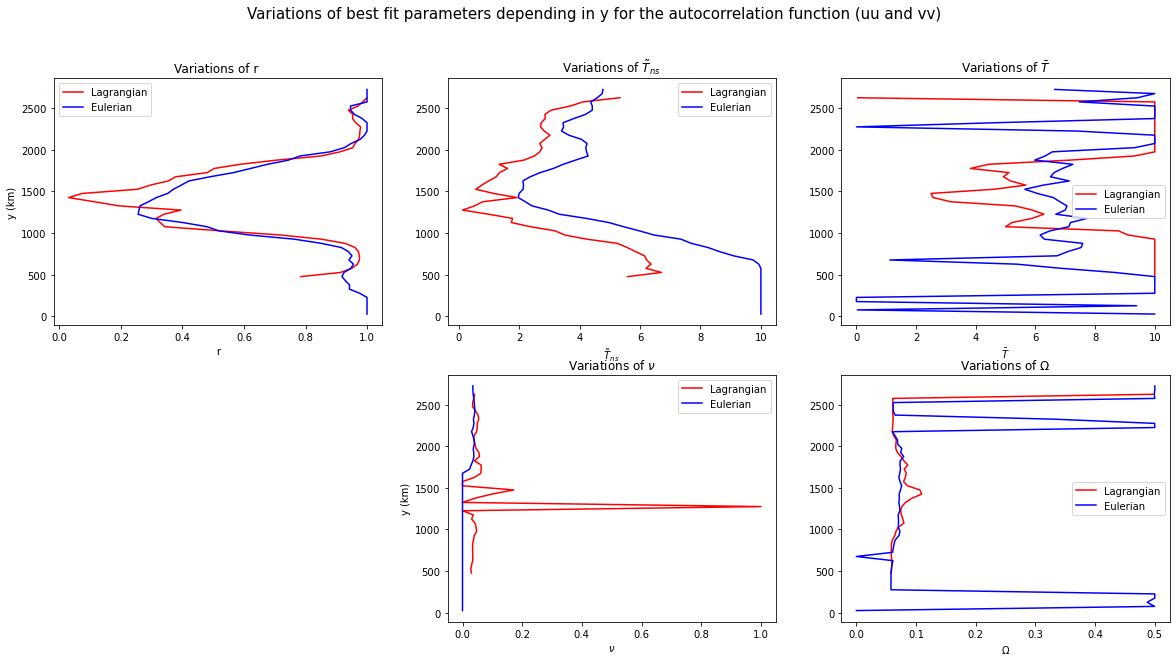

In [79]:
ybins = uu.y_bins.values[:]
fig,ax = plt.subplots(2,3,figsize=(20,10))
ax[0,0].plot(Lparams[:,-1],ybins,'r',label='Lagrangian')
ax[0,0].plot(Eparams[:,-1],ybins,'b',label='Eulerian')
ax[0,0].legend()
ax[0,0].set_title('Variations of r ')
ax[0,0].set_ylabel('y (km)');ax[0,0].set_xlabel('r')
ax[0,1].plot(Lparams[:,0],ybins,'r',label='Lagrangian')
ax[0,1].plot(Eparams[:,0],ybins,'b',label='Eulerian')
ax[0,1].legend();ax[0,1].set_xlabel(r'$\tilde T_{ns}$')
ax[0,1].set_title(r'Variations of $\tilde T_{ns}$ ')
ax[0,2].plot(Lparams[:,2],ybins,'r',label='Lagrangian')
ax[0,2].plot(Eparams[:,2],ybins,'b',label='Eulerian')
ax[0,2].legend();ax[0,2].set_xlabel(r'$\bar T$')
ax[0,2].set_title(r'Variations of $\bar T$ ')
ax[1,1].plot(Lparams[:,1],ybins,'r',label='Lagrangian')
ax[1,1].plot(Eparams[:,1],ybins,'b',label='Eulerian')
ax[1,1].legend();ax[1,1].set_xlabel(r'$\nu$')
ax[1,1].set_title(r'Variations of $\nu$ ')
ax[1,2].plot(Lparams[:,3],ybins,'r',label='Lagrangian')
ax[1,2].plot(Eparams[:,3],ybins,'b',label='Eulerian')
ax[1,2].legend();ax[1,2].set_xlabel(r'$\Omega$')
ax[1,1].set_ylabel('y (km)')
ax[1,2].set_title(r'Variations of $\Omega$ ')
fig.delaxes(ax[1,0])
fig.suptitle('Variations of best fit parameters depending in y for the autocorrelation function (uu and vv)',fontsize=15)

### Comments :
1) r : the values are r do not differ a lot btw the two perspectives (confidence intervals remain to be computed) => low in the jet area and close to one outside.\
2) $\tilde T_{ns}$ : for y>1000km, remains lower than 6 days, with the lowest values around 2days in eulerian and <1 in lagrangian. In general, the eulerian non-stationarity timescales are lower than the lagrangian one.\
3) $\bar T$ : Anomalies in eulerian for low (<700km) and high (>2000km) y. Outside of these areas the eulerian timescale is between 6 and 8 days while the lagrangian one is btw 2 and 6 days.\
The values found for $\nu$ and $\Omega$ have some anomalies especially in eulerian for $\Omega$.

